In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-04-19 09:22:17.218582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 09:22:18.517360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/danil/PycharmProjects/image_classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-19 09:22:20.410770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

Подсчитаем общее количество изображений:

In [2]:
data_dir = pathlib.Path("images")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

19794


Взглянем на одно из изображений:

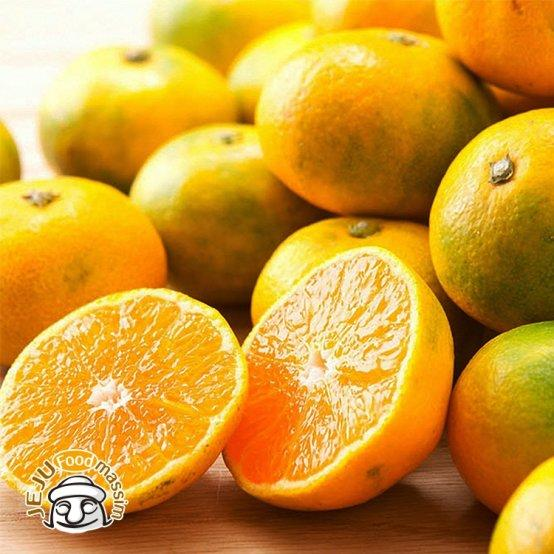

In [3]:
fruits = list(data_dir.glob('фрукты/*'))
PIL.Image.open(fruits[0])

Определим параметры - размер пакета (batch), высоту и ширину изображений:

In [4]:
batch_size = 32
img_height = 256
img_width = 256

Загрузим наши данные, выделив для обучения 70%:

In [54]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="training",
  label_mode='categorical',  
  seed=2,
  image_size=(img_height, img_width),
  pad_to_aspect_ratio=True,  
  batch_size=batch_size)

Found 19794 files belonging to 40 classes.
Using 13856 files for training.


Для валидации загрузим оставшиеся 30%:

In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="validation",
  label_mode='categorical',   
  seed=2,
  image_size=(img_height, img_width),
  pad_to_aspect_ratio=True,  
  batch_size=batch_size)

Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Разделим валидационные данные на тестовую и валидационную выборки:

In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

Взглянем на несколько изображений:

2024-04-19 10:34:05.323687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


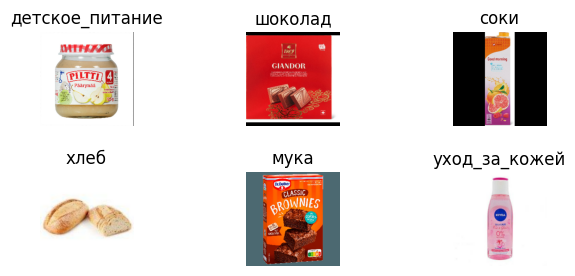

In [61]:
class_names = train_ds.class_names

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(2):
  for i in range(6):  
    label = class_names[np.argmax(labels[i])]
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=0.5, wspace=None, hspace=0.5)

Зададим архитектуру нашей модели:

In [20]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_width, img_height, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),  
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),   
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

Определим коллбэки:

In [21]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [22]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/simple_model.weights.h5",
    save_weights_only=True)

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']  
)

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 252, 252, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,470,056 (28.50 MB)

 Trainable params: 7,470,056 (28.50 MB)

 Non-trainable params: 0 (0.00 B)

Запустим обучение:

In [25]:
%%time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[checkpoint_cb, es]
)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.0663 - loss: 3.5747 - val_accuracy: 0.2255 - val_loss: 2.8646
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.1951 - loss: 2.9041 - val_accuracy: 0.3596 - val_loss: 2.3495
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.3210 - loss: 2.4386 - val_accuracy: 0.4338 - val_loss: 2.0820
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.4252 - loss: 2.0309 - val_accuracy: 0.4916 - val_loss: 1.8746
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.5220 - loss: 1.6249 - val_accuracy: 0.5010 - val_loss: 1.8145
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.5873 - loss: 1.3742 - val_accuracy: 0.5219 - val_loss: 1.8147
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.6543 - loss: 1.1360 - val_accuracy: 0.5354 - val_loss: 1.8461
CPU times: user 11min 2s, sys: 26 s, total: 11min 28s
Wall time: 2min 45s


Протестируем модель на нашей тестовой выборке:

In [26]:
results = model.evaluate(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4725 - loss: 1.9258


In [27]:
results

[1.9275929927825928, 0.4744623601436615]

In [28]:
predictions = model.predict(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


Иллюстрация того, какие классы были предсказаны для разных изображений. \
В скобках указан предсказанный класс

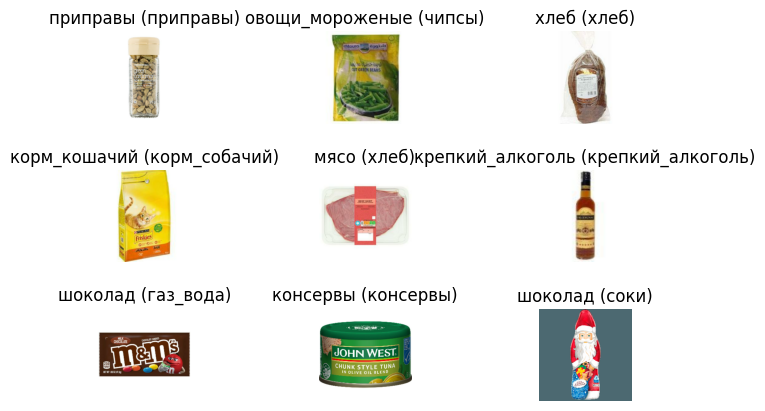

In [36]:
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)

Построим матрицу ошибок:

2024-04-19 10:40:26.236692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


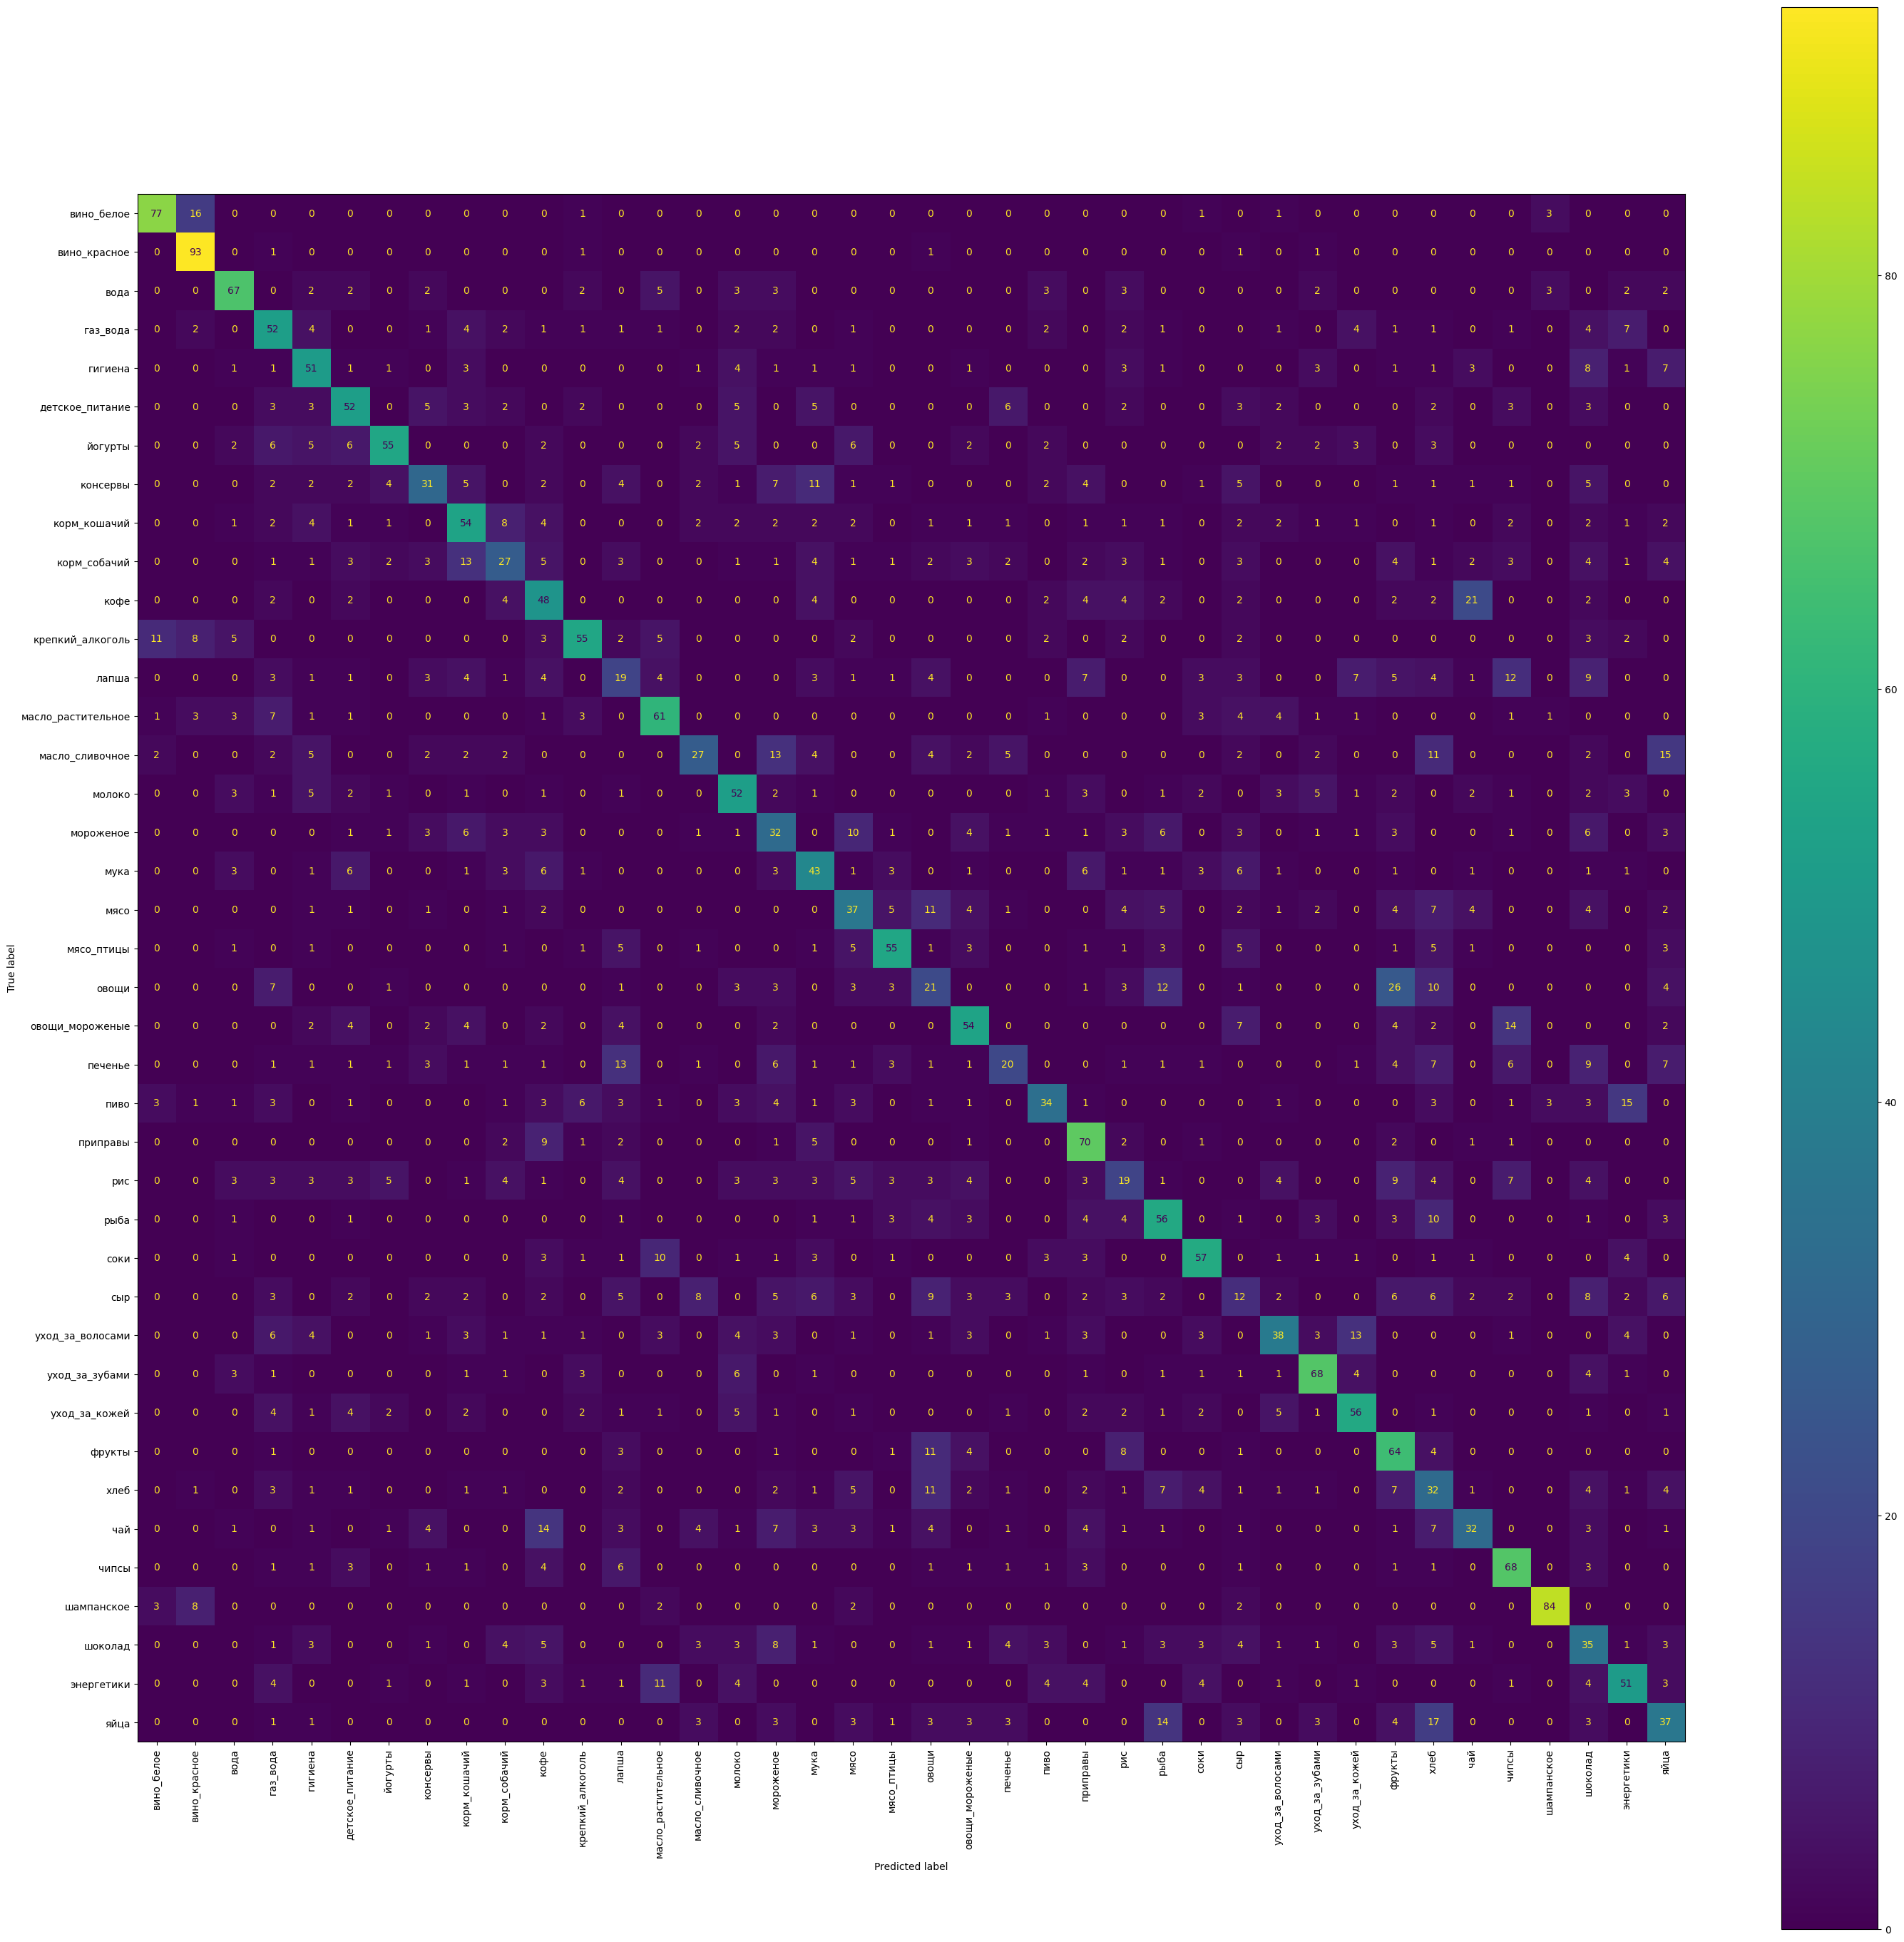

In [72]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

Сохраним натренированную модель:

In [73]:
model.save('ready_models/simple_model.keras')